In [1]:
from __future__ import print_function

"""
A reference implementation of cavity quantum electrodynamics 
configuration interactions singles.
"""

__authors__   = ["Jon McTague", "Jonathan Foley"]
__credits__   = ["Jon McTague", "Jonathan Foley"]

__copyright_amp__ = "(c) 2014-2018, The Psi4NumPy Developers"
__license__   = "BSD-3-Clause"
__date__      = "2021-01-15"

# ==> Import Psi4, NumPy, & SciPy <==
import psi4
import numpy as np
import scipy.linalg as la
import time
from helper_cqed_rhf import *
from helper_cis import *
from helper_cs_cqed_cis import *
from psi4.driver.procrouting.response.scf_response import tdscf_excitations

# Set Psi4 & NumPy Memory Options
psi4.set_memory('2 GB')
#psi4.core.set_output_file('output.dat', False)

numpy_memory = 2


In [8]:
# functions for Pauli-Fierz and Jaynes-Cummings model Hamiltonians

def pauli_fierz(e1, e2, omega, lam, mu_g, mu_e, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_mu_g = np.dot(lam, mu_g)
    l_d_mu_e = np.dot(lam, mu_e)
    l_d_tdm  = np.dot(lam, mu_eg)
    
    H[0,0] = e1 + 0.5 * l_d_mu_g ** 2
    H[1,1] = e1 + omega + 0.5 * l_d_mu_g ** 2
    H[2,2] = e2 + 0.5 * l_d_mu_e ** 2
    H[1,2] = np.sqrt(omega/2) * l_d_tdm
    H[2,1] = np.sqrt(omega/2) * l_d_tdm

    
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    return vals[0], vals[1], vals[2]

def jaynes_cummings(e1, e2, omega, lam, mu_eg):
    H = np.zeros((3,3),dtype=complex)
    l_d_tdm = np.dot(lam, mu_eg)
    H[0,0] = e1 + omega
    H[1,1] = e2
    H[0,1] = np.sqrt(omega/2) * l_d_tdm
    H[1,0] = np.sqrt(omega/2) * l_d_tdm
    # diagonalize
    vals, vecs = la.eig(H)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    return vals[0], vals[1]


# Quick validation
In the next cell, we will just run a quick test of helper_cis() and helper_cqed_cis() against psi4's CIS.
Note that helper_cis is just ordinary cis but also returns the dipole expectation value of
excited CIS states, which to my knowledge is not available through psi4.
The function helper_cs_cqed_cis() is the cqed-cis method in the coherent state basis.
If the lambda_vector = 0, then all three of these methods should return the same excited-state energies.

In [5]:
mol_str = """
Mg
H 1 1.3
symmetry c1
1 1
"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True, 
               'scf_type': 'pk'}

# set psi4 options and geometry
psi4.set_options(options_dict)
mol = psi4.geometry(mol_str)

om = 0.
lam = np.array([0.,0.,0.])

n_states = 5

# run psi4 SCF
psi4_rhf_e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
# calculate the excited-state energies and save them to a dictionary called 'res'
res = tdscf_excitations(wfn, states=n_states, triplets = "NONE", tda=True)

# parse res for excitation energies
psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]

# run helper_cis()
cis_e, cis_mu, tdm = cis(mol_str, options_dict)

# run helper_cs_cqed_cis()
cqed_dict = cs_cqed_cis(lam, mol_str, options_dict, om)

cqed_cis_e = cqed_dict['cqed_cis excitation energies']
scf_e = cqed_dict['rhf_energy']

# collect corresponding excitation energies for comparison
cqed_cis_to_compare = cqed_cis_e[::2]

# check to see that the cis energies match psi4s!
assert( np.isclose(psi4_rhf_e, scf_e))
assert( np.allclose(psi4_excitation_e, cis_e[:n_states]))
assert( np.allclose(psi4_excitation_e, cqed_cis_to_compare[1:n_states+1]))
print(cis_mu[:,0])


Number of occupied orbitals: 6
Frequency   is  0.0
Om Coupling is  0.0
-199.85744399880633

Start SCF iterations:

Canonical RHF One-electron energy = -285.7424508862660559
CQED-RHF One-electron energy = -285.7424508862660559
Nuclear repulsion energy = 4.8847127138769233
Dipole energy = 0.0000000000000000
SCF Iteration   1: Energy = -199.8574439988283018   dE = -1.99857E+02   dRMS = 1.39184E-08
SCF Iteration   2: Energy = -199.8574439988290976   dE = -7.95808E-13   dRMS = 3.89537E-09
Performed QED-RHF on the following molecule

Mg
H 1 1.3
symmetry c1
1 1

Total time for SCF iterations: 0.007 seconds 

QED-RHF   energy: -199.85744400 hartree
Psi4  SCF energy: -199.85744400 hartree
[-2.81307263e-15 -1.15690498e-15 -1.57800173e+00]


In [6]:
# template for the z-matrix for MgH+
mol_tmpl = """Mg
H 1 **R**
symmetry c1
1 1"""

# options dict
options_dict = {'basis': 'cc-pVDZ',
               'save_jk': True,
               'scf_type' : 'pk'}

psi4.set_options(options_dict)


# MgH+ Polaritonic Potential Energy Surfaces
Create a template for the z-matrix that can be modified for different bond-lengths

Run a scan of the SCF, CIS, and CS-CQED-CIS energies

In [15]:
# set psi4 options
psi4.set_options(options_dict)
# array of bondlengths for MgH+
r_array = np.array([1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])

# arrays to hold psi4 cis quantities to fit the model PF Hamiltonian with
# array for transition dipole moments
tdm_array = np.zeros((3, len(r_array)))

# array for total diplole of ground and excited state 
dipole_array = np.zeros((3,2,len(r_array)))

# array for ordinary cis
cis_energy_array = np.zeros((5,len(r_array)))

# array to hold the cs-cqed-cis energies
# array for cqed cis
cqed_cis_energy_array = np.zeros((5,len(r_array)),dtype=complex)

# array for model Pauli-Fierz energies
pf = np.zeros((3,len(r_array)),dtype=complex)

# array for Jaynes-Cummings energies
jc = np.zeros((2,len(r_array)),dtype=complex)

# electric field strength 
lam_z = 0.005

# photon energy
om_r = 4.75 / 27.211

# approximate maximum value of transition dipole moment in a.u.
max_tdm = 2.25

# approximate max value of g
g_max = np.sqrt(om_r/2) * lam_z * max_tdm

print(" value of gamma to cross over from weak to strong coupling:", 4 * g_max)
om = om_r - 4 * (g_max/2) * 1j

# lambda vector
lam = np.array([0,0,lam_z])




# loop over the different bond-lengths, create different instances
# of MgH+ molecule and compute and store various quantities
ctr = 0
for r in r_array:
    molstr = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(molstr)
    e, wfn = psi4.energy("scf/cc-pVDZ", return_wfn=True, molecule=mol)
    
    # confirm our cis agrees with psi4
    res = tdscf_excitations(wfn, states=3, triplets = "NONE", tda=True)
    
    # parse res for excitation energies
    psi4_excitation_e = [r["EXCITATION ENERGY"] for r in res]
    
    cis_e, cis_mu, tdm = cis(molstr, options_dict)
    
    cis_energy_array[0,ctr] = e
    cis_energy_array[1:5,ctr] = e+cis_e[0:4]
    
    pf[0,ctr], pf[1,ctr], pf[2,ctr] = pauli_fierz(e, e+cis_e[0], om, lam, cis_mu[:,0], cis_mu[:,1], tdm)
    jc[0,ctr], jc[1,ctr] = jaynes_cummings(e, e+cis_e[0], om, lam,  tdm)
    
    assert np.isclose(cis_e[0], psi4_excitation_e[0])
    assert np.isclose(cis_e[1], psi4_excitation_e[1])
    
    cqed_dict = cs_cqed_cis(lam, molstr, options_dict, om, complex_coupling=True)
    
    # get cqed-rhf energy
    cqed_scf_e = cqed_dict['cqed_rhf_energy']
    # get cqed-cis excitation energies
    cqed_cis_e = cqed_dict['cqed_cis excitation energies']
    # store to arrays
    cqed_cis_energy_array[0:5,ctr] = cqed_scf_e+cqed_cis_e[0:5]
    #f.write("%6.3f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f  \n" % 
    #        (r, cis_energy_array[0,ctr]+np.real(om), cis_energy_array[1,ctr], 
    #        np.real(cqed_cis_energy_array[1,ctr]),np.imag(cqed_cis_energy_array[1,ctr]), 
    #        np.real(cqed_cis_energy_array[2,ctr]),np.imag(cqed_cis_energy_array[2,ctr])))
    ctr+=1
    

 

 value of gamma to cross over from weak to strong coupling: 0.013294501874419162

Number of occupied orbitals: 6
Frequency   is  (0.17456175811252803-0.006647250937209581j)
Om Coupling is  (0.17456175811252803-0.006647250937209581j)
-199.85744399880633

Start SCF iterations:

Canonical RHF One-electron energy = -285.7424508862660559
CQED-RHF One-electron energy = -285.7424924690349144
Nuclear repulsion energy = 4.8847127138769233
Dipole energy = 0.0000943132492553
SCF Iteration   1: Energy = -199.8573946963478534   dE = -1.99857E+02   dRMS = 2.27588E-06
SCF Iteration   2: Energy = -199.8573947033628713   dE = -7.01502E-09   dRMS = 8.26191E-07
Performed QED-RHF on the following molecule
Mg
H 1 1.3
symmetry c1
1 1
Total time for SCF iterations: 0.007 seconds 

QED-RHF   energy: -199.85739470 hartree
Psi4  SCF energy: -199.85744400 hartree

Number of occupied orbitals: 6
Frequency   is  (0.17456175811252803-0.006647250937209581j)
Om Coupling is  (0.17456175811252803-0.006647250937209581j)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


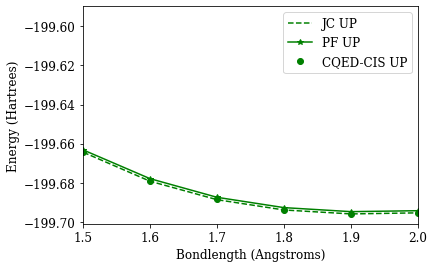

In [20]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

#plt.plot(r_array, cis_energy_array[0,:]+om, 'red', label='X,1')
#plt.plot(r_array, cis_energy_array[1,:], 'blue', label='A,0')
#plt.plot(r_array, jc[0,:], 'b--', label="JC LP")
plt.plot(r_array, jc[1,:], 'g--', label="JC UP")
#plt.plot(r_array, pf[1,:], 'b-*', label="PF LP")
plt.plot(r_array, pf[2,:], 'g-*', label="PF UP")
#plt.plot(r_array, cqed_cis_energy_array[1,:], 'bo', label="CQED-CIS LP")
plt.plot(r_array, cqed_cis_energy_array[2,:], 'go', label="CQED-CIS UP")

plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
#plt.savefig("mghplus_stretch.eps")
plt.show()

OLD CODE BELOW!

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


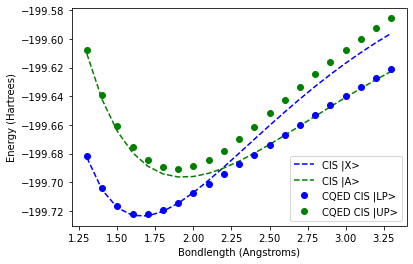

In [15]:
from matplotlib import pyplot as plt
# plot the ordinary cis energies vs the cs-cqed-cis energies

plt.plot(r_array, cis_energy_array[0,:]+np.real(om), 'b--', label="CIS |X>")
plt.plot(r_array, cis_energy_array[1,:], 'g--', label="CIS |A>")
plt.plot(r_array, cqed_cis_energy_array[1,:], 'bo', label="CQED CIS |LP>")
plt.plot(r_array, cqed_cis_energy_array[2,:], 'go', label="CQED CIS |UP>")
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
plt.show()

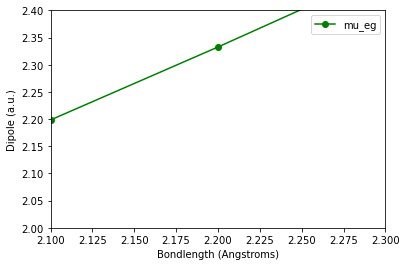

0.2954333749870925
0.17456175811252803


In [13]:
# plot dipole quantities
#plt.plot(r_array, dipole_array[2,0,:], 'r-o', label="<mu>_g")
#plt.plot(r_array, dipole_array[2,1,:], 'b-o', label="<mu>_e")
plt.plot(r_array, np.abs(tdm_array[2,:]), 'g-o', label="mu_eg")
plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Dipole (a.u.)")
plt.xlim(2.1,2.3)
plt.ylim(2.0,2.4)
plt.legend()
plt.show()

print(np.sqrt(np.real(om)/2))
print(np.real(om))

#### Model system
We will consider the diatomic cation MgH+ in a cavity chosen such that it can trap a photon with a 
frequency of $\hbar \omega = 4.3$ eV. 
We will compute the singlet ground state and first singlet excited state potential energy surfaces along the
Mg-H+ stretch coordinate using time-dependent density functional theory.  We denote the ground 
state ket as $|g\rangle$ with an associated energy eigenvalue $E_g(R)$, and the excited-state $|e\rangle$
with associated energy eigenvalue $E_e(R)$ where $R$ is the bondlength.  The transition dipole
moment between $|g\rangle$ and $|e\rangle$ will also be computed using CIS, yielding $\mu_{ge}(R)$.
Both the ground and excited states have total dipole moments associated with them, $\langle \mu \rangle_g$ and
$\langle \mu \rangle_e$, respectively.

We will consider two quantum states for the photon - no photon in the cavity, denoted by $|0\rangle$ with associated energy eigenvalue $0$
and one photon in the cavity, denoted by $|1\rangle$ with associated energy eigenvalue $\frac{ \hbar \omega}{2}$.  
We will model this system with a Pauli-Fierz Hamiltonian that can be written as:

$$ \hat{H}_{PF} = E_g(R) \hat{a}_g^{\dagger} \hat{a}_g + E_e(R) \hat{a}_e^{\dagger} \hat{a}_e + 
\hbar \omega\hat{b} \hat{b}^{\dagger}  
+ \frac{1}{2} \left( \lambda \cdot \mu(R) \right)^2
- \sqrt{\frac{\omega}{2}} \left( \lambda \cdot \mu(R) \right) \left(\hat{b}^{\dagger} + \hat{b}\right)
$$
The polaritonic potential energy surfaces may be obtained by building a Hamiltonian matrix in the following basis and diagonalizing as a function of the bond length $R$: $ |\phi\rangle \in \{|g,0\rangle , |g,1\rangle , |e,0\rangle. $


This matrix as a function of the bond-length $R$ is as follows:
\begin{equation}
{\bf H}(R)
  \mbox{=} 
  \begin{array}{c|cccc}
       & |g,0\rangle & |g,1\rangle & |e,0\rangle \\
    \hline
    \langle g,0| & E_g(R) + (\lambda \cdot \langle \mu \rangle_g)^2  &     0   & 0  \\
    \langle g,1| & 0        &   E_g(R) +  \hbar \omega + \frac{1}{2}(\lambda \cdot \langle \mu \rangle_g)^2  & \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{ge} \\
    \langle e,0| & 0        &    \sqrt{\frac{\omega}{2}} \lambda \cdot \mu_{ge} & E_e(R) + \frac{1}{2}(\lambda \cdot \langle \mu \rangle_e)^2\\
  \end{array}
\end{equation}

In [16]:
from numpy import linalg as LA
from scipy.interpolate import InterpolatedUnivariateSpline

# fit splines in case you want polaritonic states at finer spacings
cis_s0_spline = InterpolatedUnivariateSpline(r_array, cis_energy_array[0,:], k=3)
cis_s1_spline = InterpolatedUnivariateSpline(r_array, cis_energy_array[1,:], k=3)

tdm_spline = InterpolatedUnivariateSpline(r_array, np.abs(tdm_array[2,:]), k=3 )

mu_g_spline = InterpolatedUnivariateSpline(r_array, dipole_array[2,0,:])
mu_e_spline = InterpolatedUnivariateSpline(r_array, dipole_array[2,1,:])

E_au = np.sqrt(om/2) * l
Htot = np.zeros((3,3), dtype=complex)

''' Polaritonic Hamiltonian will have the following structure

    | E_g(r)+0.5*(l.<mu>_g)^2                   0                                         0              |
    | 0                           E_g(r) + h*om + 0.5*(l.<mu>_g)^2               E_au*mu_eg          |
    | 0                                     E_au*mu_eg                      E_e(r) + 0.5*(l.<mu>_e)^2    |
    
'''

pl_1 = np.zeros_like(r_array)
pl_2 = np.zeros_like(r_array)
pl_3 = np.zeros_like(r_array)
# build the hamiltonian matrix and diagonalize at each geometry
for i in range(0,len(r_array)):
    Htot[0,0] = cis_s0_spline(r_array[i]) + 0.5 * (l * mu_g_spline(r_array[i]))**2
    Htot[1,1] = cis_s0_spline(r_array[i]) + om + 0.5 * (l * mu_g_spline(r_array[i]))**2
    Htot[1,2] = E_au * tdm_spline(r_array[i])
    Htot[2,1] = E_au * tdm_spline(r_array[i])
    Htot[2,2] = cis_s1_spline(r_array[i]) + 0.5 * (l * mu_e_spline(r_array[i]))**2
    
    # diagonalize
    vals, vecs = LA.eig(Htot)
    idx = vals.argsort()[::1]
    vals = vals[idx]
    # store eigenvalues
    pl_1[i] = np.real(vals[0])
    pl_2[i] = np.real(vals[1])
    pl_3[i] = np.real(vals[2])





/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


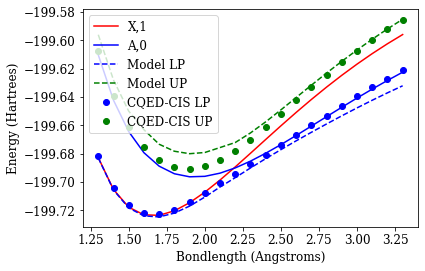

In [17]:
# now plot the ordinary cis energies vs both the model and the cs-cqed-cis energies
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams


rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

plt.plot(r_array, cis_s0_spline(r_array)+om, 'red', label='X,1')
plt.plot(r_array, cis_s1_spline(r_array), 'blue', label='A,0')
plt.plot(r_array, pl_2, 'b--', label="Model LP")
plt.plot(r_array, pl_3, 'g--', label="Model UP")
plt.plot(r_array, cqed_cis_energy_array[1,:], 'bo', label="CQED-CIS LP")
plt.plot(r_array, cqed_cis_energy_array[2,:], 'go', label="CQED-CIS UP")

plt.xlabel("Bondlength (Angstroms)")
plt.ylabel("Energy (Hartrees)")
plt.legend()
#plt.savefig("mghplus_stretch.eps")
plt.show()

In [35]:


f = open('MgH_ccpVDZ_Ez_5mH_om_4.75_0.1j_ComplexCoupling.txt', 'w')
stri = "radius; CIS X,1; CIS A,0; Model LP; Model UP; CQED-CIS LP; CQED-CIS UP"
f.write(" %s \n" % stri)
for i in range(len(r_array)):
    f.write("%6.3f %12.6f %12.6f %12.6f %12.6f %12.6f %12.6f \n" % 
            (r_array[i], cis_energy_array[0,i]+np.real(om), cis_energy_array[1,i], 
            np.real(pl_2[i]), np.real(pl_3[i]), np.real(cqed_cis_energy_array[1,i]), np.real(cqed_cis_energy_array[2,i])))
f.close()

In [ ]:
''' 
# this follows the ci-vector across the curve crossing
    # that occurs btw |X,1> and |A,0> without coupling
    if ctr>0 and np.isclose(l,0):
        ol11 = np.dot(cqed_cis_c[:,1], old_vecs[:,1])
        ol22 = np.dot(cqed_cis_c[:,2], old_vecs[:,2])
        ol12 = np.dot(cqed_cis_c[:,1], old_vecs[:,2])
        ol21 = np.dot(cqed_cis_c[:,2], old_vecs[:,1])

        print("Overlaps for r = ",r)
        print("<1|1>:",ol11)
        print("<2|2>:",ol22)
        print("<1|2>:",ol12)
        print("<2|1>:",ol21)
        if np.abs(ol12)>np.abs(ol11):
            temp_c1 = np.copy(cqed_cis_c[:,2])
            temp_c2 = np.copy(cqed_cis_c[:,1])
            temp_e1 = cqed_cis_e[2]
            temp_e2 = cqed_cis_e[1]
            
            cqed_cis_c[:,1] = np.copy(temp_c1)
            cqed_cis_c[:,2] = np.copy(temp_c2)
            cqed_cis_e[1] = temp_e1
            cqed_cis_e[2] = temp_e2
            
    old_vecs = np.copy(cqed_cis_c)
    #scf_e, cqed_cis_e, cqed_cis_c = cqed_cis(lam, molstr, options_dict, om)
    #cqed_cis_energy_array[0,ctr] = scf_e+om
'''